In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
file = os.path.join("data", "notex_all.csv")

data = pd.read_csv(file, delimiter='\t')

In [3]:
# take a sample of records to play with
small_num = 100_000
sample = data[:small_num]

text = sample.text
label = sample.label

text_train = text[:small_num//2]
text_test = text[small_num//2:]

label_e = LabelEncoder()
y_train = to_categorical(label_e.fit_transform(label[:small_num//2]))
y_test = to_categorical(label_e.transform(label[small_num//2:]))

In [4]:
text_train[:3]

0    On the interplay between star formation and fe...
1    Transversal Homotopy Monoids of Complex Projec...
2    Remarks on some typical assumptions in dynamo ...
Name: text, dtype: object

In [5]:
y_train[:3]

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [52]:
np.unique(label)

array(['cs', 'math', 'phys', 'q-bio', 'q-fin', 'stat'], dtype=object)

In [6]:
# compute class weights for keras (obtained from the whole of train sample)

n_classes = len(np.unique(label))

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(label), label)  # ~ 1 / np.unique(label, return_counts=True)[1]
class_weights

array([ 1.25995363,  0.72799278,  0.27618053, 13.15443304, 31.15264798,
        9.63948332])

In [7]:
# see how many unique words are there globally (unique_words)
# and how many words are in the longest text (max_word_count)
# save those annoyingly confusing integers to feed later into keras

count_v = CountVectorizer(min_df = 1, strip_accents='unicode')
word_counts_train = count_v.fit_transform(text_train)

unique_words = word_counts_train.shape[1]
num_words = unique_words + 1
max_word_count = np.max(np.sum(word_counts_train, axis=1))
padded_length = int(1.05*max_word_count)

print(f"Counted {unique_words} unique words in the whole train dataset.")
print(f"Take numbers 1 to 'num_words'={num_words} as numerical labels for the unique words, and 0 for 'silence'.")
print(f"A single record has at most {max_word_count} words.")
print(f"The text will be tokenized into sequences of numerical labels and put into arrays of length \
'padded_length'={padded_length} left-padded with zeros. The extra 5% of length is there in case a longer text \
would need to be tokenized and classified later (e.g. from a test dataset).")

Counted 83099 unique words in the whole train dataset.
Take numbers 1 to 'num_words'=83100 as numerical labels for the unique words, and 0 for 'silence'.
A single record has at most 647 words.
The text will be tokenized into sequences of numerical labels and put into arrays of length 'padded_length'=679 left-padded with zeros. The extra 5% of length is there in case a longer text would need to be tokenized and classified later (e.g. from a test dataset).


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
tokenizer = Tokenizer(num_words=unique_words, lower=True)
tokenizer.fit_on_texts(text_train)

sequences_train = tokenizer.texts_to_sequences(text_train, padding='post')
sequences_test = tokenizer.texts_to_sequences(text_test, padding='post')

In [10]:
text_train[0]

'On the interplay between star formation and feedback in galaxy formation simulations.  We investigate the star formation-feedback cycle in cosmological galaxy formation simulations, focusing on progenitors of Milky Way (MW)-sized galaxies. We find that in order to reproduce key properties of the MW progenitors, such as semi-empirically derived star formation histories and the shape of rotation curves, our implementation of star formation and stellar feedback requires 1) a combination of local early momentum feedback via radiation pressure and stellar winds and subsequent efficient supernovae feedback, and 2) efficacy of feedback that results in self-regulation of the global star formation rate on kiloparsec scales. We show that such feedback-driven self-regulation is achieved globally for a local star formation efficiency per free fall time of  _LATEX_ . Although this value is larger that the  _LATEX_  value usually inferred from the Kennicutt-Schmidt (KS) relation, we show that it is

In [11]:
sequences_train[0][:15]

[13, 1, 2232, 38, 158, 209, 3, 941, 5, 259, 209, 205, 7, 239, 1]

In [12]:
X_train = pad_sequences(sequences_train, maxlen=padded_length)
X_test = pad_sequences(sequences_test, maxlen=padded_length)

In [13]:
from keras.models import Sequential
from keras.layers import *

In [14]:
# https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

In [14]:
from keras import backend as K

def macroPrec(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec

def macroRecall(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) )
    
    return macroF1


def fuzzy_macroF1_flip(y_true, y_pred):
    # a custom loss function
    # no clippping or rounding as those are not differentiable
    
    def recall(y_true, y_pred):

        true_positives = K.sum(y_true * y_pred, axis=0)
        actual_ones = K.sum(y_true, axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(y_true * y_pred, axis=0)
        positives = K.sum(y_pred, axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) ) 
    
    return 1-macroF1

In [16]:
def microRecall(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_ones = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (all_ones + K.epsilon())
    return recall


def microPrec(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (positives + K.epsilon())
    
    return precision


def microF1(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        all_ones = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (all_ones + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    microF1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    return microF1

In [17]:
# some global learning settings
# recall that we have already fixed train and test data, number of classes, class_weights

batch_size = 3000
patience = 2
optimizer = 'adam' # 'rmsprop'

In [18]:
# auxiliary functions

# choose callback functions to be given in model.fit(...)
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

def callbacks(LRfactor=0.1, save_as = None):
    if save_as:
        return [#ReduceLROnPlateau(factor=LRfactor, patience = patience//2),
                EarlyStopping(patience=patience),
                #EarlyStopping(monitor='macroF1', mode='max', patience=patience),
                ModelCheckpoint(filepath=save_as+f'_trained_on_{len(X_train)//1000}k', save_best_only=True)]
    else:
        return [#ReduceLROnPlateau(factor=LRfactor, patience = patience//2),
                EarlyStopping(patience=patience),
                #EarlyStopping(monitor='macroF1', mode='max', patience=patience)
               ]


    
# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
import matplotlib.pyplot as plt
plt.style.use('seaborn')

def plot_history(history):
    
    plt.figure(figsize=(18, 5))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 3, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 3, 2)
    markers = ['b', 'r',  'g', 'y']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history.history[metric]
        val_results = history.history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    lr = history.history['lr'] # learning rate
    plt.plot(x, lr, 'k', label='Learning rate')
    plt.title('Learning rate')  
    plt.legend()

In [19]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.history = None
        self.results = None
        
        self.model = Sequential()
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=200):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=class_weights,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def save(self, file):
        self.model.save(file+f"_trained_on_{len(X_train)//1000}k.h5")
        
    def evaluate(self):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        return self.results
    
    def plot(self):
        plot_history(self.history)
 
    

In [48]:
# simplistic "baseline" net
# relies on learning the embedding for words
# which gest averaged over the whole text in a single input

layers1 = [Embedding(input_dim=num_words, output_dim=300, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]
loss1 = "categorical_crossentropy"
metrics1 = [macroPrec, macroF1, macroRecall, "categorical_accuracy"]
callbacks1 = callbacks()

model1 = BlackBox(layers=layers1, loss=loss1, metrics=metrics1, callbacks=callbacks1)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 679, 300)          17434200  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1806      
Total params: 17,436,006
Trainable params: 17,436,006
Non-trainable params: 0
_________________________________________________________________


In [49]:
model1.fit(epochs=200)

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 43s 2ms/step - loss: 1.7435 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - categorical_accuracy: 0.5742 - val_loss: 1.6786 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00 - val_categorical_accuracy: 0.6218
Epoch 2/200
20000/20000 [==============================] - 48s 2ms/step - loss: 1.6182 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - categorical_accuracy: 0.6117 - val_loss: 1.5335 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00 - val_categorical_accuracy: 0.6182
Epoch 3/200
20000/20000 [==============================] - 50s 2ms/step - loss: 1.4601 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - categorical_accuracy: 0.6080 - val_loss: 1.3578 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00 - 

Epoch 54/200
20000/20000 [==============================] - 48s 2ms/step - loss: 0.1228 - macroPrec: 0.8480 - macroF1: 0.5928 - macroRecall: 0.5510 - categorical_accuracy: 0.9683 - val_loss: 0.2491 - val_macroPrec: 0.6195 - val_macroF1: 0.4796 - val_macroRecall: 0.4611 - val_categorical_accuracy: 0.9126
Epoch 55/200
20000/20000 [==============================] - 47s 2ms/step - loss: 0.1193 - macroPrec: 0.8816 - macroF1: 0.6011 - macroRecall: 0.5563 - categorical_accuracy: 0.9694 - val_loss: 0.2481 - val_macroPrec: 0.6638 - val_macroF1: 0.5045 - val_macroRecall: 0.4765 - val_categorical_accuracy: 0.9126
Epoch 56/200
20000/20000 [==============================] - 51s 3ms/step - loss: 0.1159 - macroPrec: 0.9154 - macroF1: 0.6161 - macroRecall: 0.5670 - categorical_accuracy: 0.9711 - val_loss: 0.2474 - val_macroPrec: 0.6610 - val_macroF1: 0.5078 - val_macroRecall: 0.4788 - val_categorical_accuracy: 0.9122
Epoch 57/200
20000/20000 [==============================] - 48s 2ms/step - loss: 0.11

In [50]:
model1.evaluate()

Loss function: categorical_crossentropy. Metrics: ['macroPrec', 'macroF1', 'macroRecall', 'categorical_accuracy']
Predicting for X_test, comparing with y_test
25000/25000 [==============================] - 22s 875us/step


[0.25401145692825317,
 0.4773567922782898,
 0.4657322039890289,
 0.4658655764770508,
 0.91224]

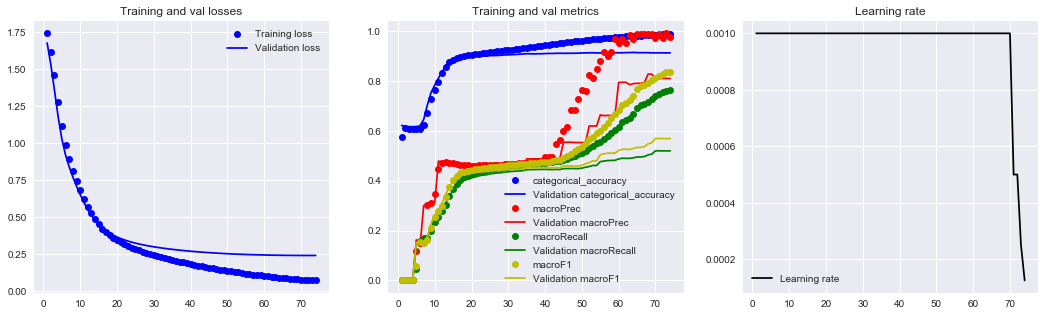

In [51]:
model1.plot()

In [52]:
# same as the simplistic net
# but with our custom semi-macroF1 loss function
# skip monitoring the 'categorical_accuracy'

layers1b = [Embedding(input_dim=num_words, output_dim=300, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]
loss1b = fuzzy_macroF1_flip
metrics1b = [macroPrec, macroF1, macroRecall]
callbacks1b = callbacks()

model1b = BlackBox(layers=layers1b, loss=loss1b, metrics=metrics1b, callbacks=callbacks1b)
model1b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 679, 300)          17434200  
_________________________________________________________________
global_average_pooling1d_3 ( (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1806      
Total params: 17,436,006
Trainable params: 17,436,006
Non-trainable params: 0
_________________________________________________________________


In [53]:
model1b.fit(epochs=200)

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 53s 3ms/step - loss: 0.8868 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - val_loss: 0.8849 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00
Epoch 2/200
20000/20000 [==============================] - 45s 2ms/step - loss: 0.8800 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - val_loss: 0.8767 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00
Epoch 3/200
20000/20000 [==============================] - 51s 3ms/step - loss: 0.8703 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - val_loss: 0.8651 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00
Epoch 4/200
20000/20000 [==============================] - 51s 3ms/step - loss: 0.8569 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - val_

Epoch 35/200
20000/20000 [==============================] - 48s 2ms/step - loss: 0.1928 - macroPrec: 0.9391 - macroF1: 0.8719 - macroRecall: 0.8244 - val_loss: 0.3818 - val_macroPrec: 0.8427 - val_macroF1: 0.6332 - val_macroRecall: 0.5787
Epoch 36/200
20000/20000 [==============================] - 51s 3ms/step - loss: 0.1807 - macroPrec: 0.9386 - macroF1: 0.8817 - macroRecall: 0.8407 - val_loss: 0.3759 - val_macroPrec: 0.8643 - val_macroF1: 0.6471 - val_macroRecall: 0.5889
Epoch 37/200
20000/20000 [==============================] - 48s 2ms/step - loss: 0.1712 - macroPrec: 0.9411 - macroF1: 0.8899 - macroRecall: 0.8525 - val_loss: 0.3714 - val_macroPrec: 0.8659 - val_macroF1: 0.6701 - val_macroRecall: 0.6102
Epoch 38/200
20000/20000 [==============================] - 47s 2ms/step - loss: 0.1632 - macroPrec: 0.9428 - macroF1: 0.8946 - macroRecall: 0.8582 - val_loss: 0.3689 - val_macroPrec: 0.8659 - val_macroF1: 0.6702 - val_macroRecall: 0.6104
Epoch 39/200
20000/20000 [==================

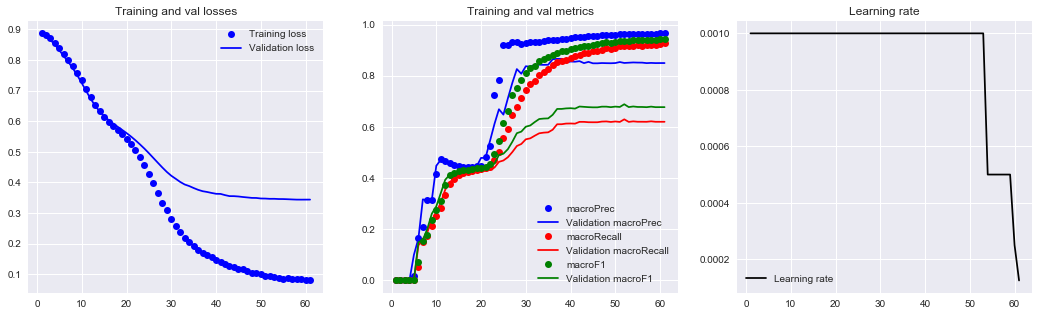

In [54]:
model1b.plot()

In [55]:
model1b.evaluate()

Loss function: fuzzy_macroF1_flip. Metrics: ['macroPrec', 'macroF1', 'macroRecall']
Predicting for X_test, comparing with y_test
25000/25000 [==============================] - 22s 886us/step


[0.5039069741439819,
 0.5040913913917542,
 0.49725184655189514,
 0.5033622889518737]

In [58]:
layers1c = [Embedding(input_dim=num_words, output_dim=300, input_length=padded_length),
           GlobalMaxPooling1D()]
loss1c = fuzzy_macroF1_flip
metrics1c = [macroPrec, macroF1, macroRecall]
callbacks1c = callbacks()

model1c = BlackBox(layers=layers1c, loss=loss1c, metrics=metrics1c, callbacks=callbacks1c)
model1c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 679, 300)          17434200  
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 1806      
Total params: 17,436,006
Trainable params: 17,436,006
Non-trainable params: 0
_________________________________________________________________


In [59]:
model1c.fit(epochs=200)

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 125s 6ms/step - loss: 0.8810 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - val_loss: 0.8735 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00
Epoch 2/200
20000/20000 [==============================] - 132s 7ms/step - loss: 0.8643 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - val_loss: 0.8564 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00
Epoch 3/200
20000/20000 [==============================] - 130s 7ms/step - loss: 0.8463 - macroPrec: 0.0000e+00 - macroF1: 0.0000e+00 - macroRecall: 0.0000e+00 - val_loss: 0.8383 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00
Epoch 4/200
20000/20000 [==============================] - 130s 6ms/step - loss: 0.8273 - macroPrec: 0.0500 - macroF1: 0.0178 - macroRecall: 0.0119 - val_loss: 0.

Epoch 35/200
20000/20000 [==============================] - 136s 7ms/step - loss: 0.0463 - macroPrec: 0.9882 - macroF1: 0.9810 - macroRecall: 0.9745 - val_loss: 0.4002 - val_macroPrec: 0.8061 - val_macroF1: 0.6156 - val_macroRecall: 0.5693
Epoch 36/200
20000/20000 [==============================] - 132s 7ms/step - loss: 0.0419 - macroPrec: 0.9888 - macroF1: 0.9815 - macroRecall: 0.9750 - val_loss: 0.3983 - val_macroPrec: 0.7878 - val_macroF1: 0.6121 - val_macroRecall: 0.5668
Epoch 37/200
20000/20000 [==============================] - 132s 7ms/step - loss: 0.0393 - macroPrec: 0.9892 - macroF1: 0.9823 - macroRecall: 0.9762 - val_loss: 0.3967 - val_macroPrec: 0.7885 - val_macroF1: 0.6125 - val_macroRecall: 0.5669
Epoch 38/200
20000/20000 [==============================] - 134s 7ms/step - loss: 0.0359 - macroPrec: 0.9896 - macroF1: 0.9833 - macroRecall: 0.9777 - val_loss: 0.3953 - val_macroPrec: 0.7885 - val_macroF1: 0.6168 - val_macroRecall: 0.5703
Epoch 39/200
20000/20000 [==============

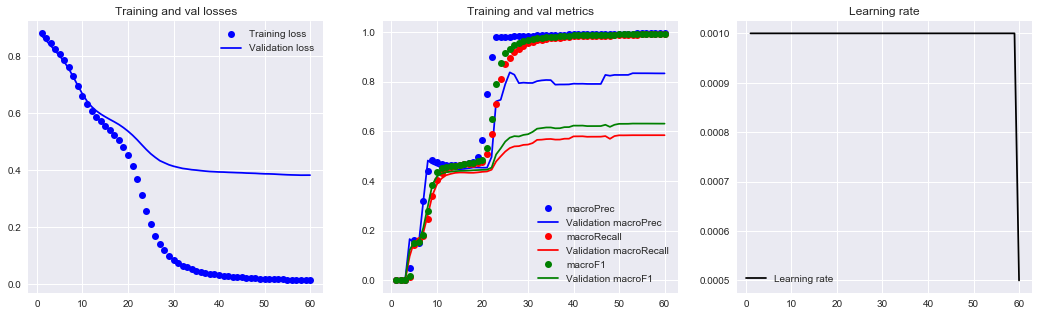

In [60]:
model1c.plot()

In [61]:
model1c.evaluate()

Loss function: fuzzy_macroF1_flip. Metrics: ['macroPrec', 'macroF1', 'macroRecall']
Predicting for X_test, comparing with y_test
25000/25000 [==============================] - 14s 579us/step


[0.5076348724746704,
 0.4906787853050232,
 0.48533454770088197,
 0.4925607475852966]

In [188]:
# a refinement (hopefully) of the previous nets:
# - dropout regularization after embedding
# - this time we do not average the text globally, but with a few-words window
#   hence the zeros from padding are being fed into learning
# - also add one dense layer before the final classification
# Let's first try again with 'categorical crossentropy'

layers2 = [Embedding(input_dim=num_words, output_dim=300, input_length=padded_length),
           #Dropout(rate=0.1, noise_shape=(batch_size, padded_length,  1)),
           AveragePooling1D(pool_size=8, strides=4, padding='valid', data_format='channels_last'),
           Flatten(),
           #Dense(20, activation='relu')
          ]
loss2 = "categorical_crossentropy"
metrics2 = [macroPrec, macroF1, macroRecall]
callbacks2 = callbacks()

model2 = BlackBox(layers=layers2, loss=loss2, metrics=metrics2, callbacks=callbacks2)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 679, 300)          17434200  
_________________________________________________________________
average_pooling1d_12 (Averag (None, 168, 300)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 50400)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 302406    
Total params: 17,736,606
Trainable params: 17,736,606
Non-trainable params: 0
_________________________________________________________________


In [189]:
model2.fit(epochs=200)

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 45s 2ms/step - loss: 1.1744 - macroPrec: 0.1144 - macroF1: 0.1179 - macroRecall: 0.1352 - val_loss: 1.0004 - val_macroPrec: 0.2135 - val_macroF1: 0.1939 - val_macroRecall: 0.1997
Epoch 2/200
20000/20000 [==============================] - 32s 2ms/step - loss: 0.9413 - macroPrec: 0.2300 - macroF1: 0.1868 - macroRecall: 0.1943 - val_loss: 0.8256 - val_macroPrec: 0.2460 - val_macroF1: 0.2229 - val_macroRecall: 0.2156
Epoch 3/200
20000/20000 [==============================] - 36s 2ms/step - loss: 0.7293 - macroPrec: 0.2940 - macroF1: 0.2516 - macroRecall: 0.2445 - val_loss: 0.5980 - val_macroPrec: 0.4381 - val_macroF1: 0.3336 - val_macroRecall: 0.3004
Epoch 4/200
20000/20000 [==============================] - 39s 2ms/step - loss: 0.5084 - macroPrec: 0.4354 - macroF1: 0.3931 - macroRecall: 0.3679 - val_loss: 0.4373 - val_macroPrec: 0.4321 - val_macroF1: 0.4098 - val_macroRecall: 0.3923

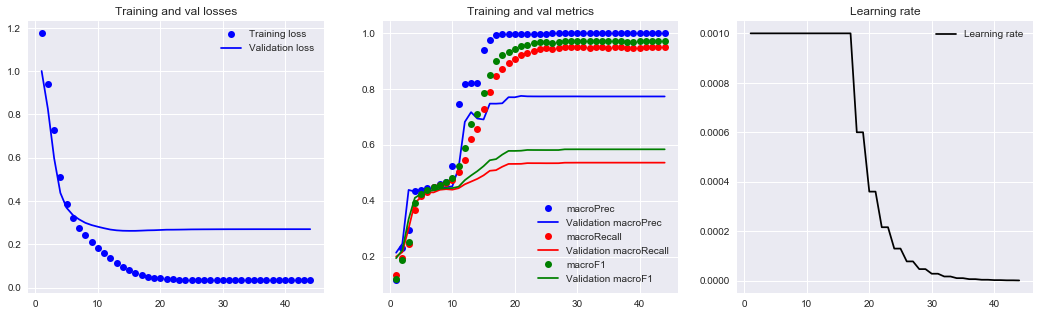

In [190]:
model2.plot()

In [26]:
model2.evaluate()

NameError: name 'model2' is not defined

In [19]:
# same as the last one except for the loss function
# Now we'll use the macroF1 of ours

layers2b = [Embedding(input_dim=num_words, output_dim=300, input_length=padded_length),
           #Dropout(rate=0.1, noise_shape=(batch_size, padded_length,  1)),
           AveragePooling1D(pool_size=8, strides=4, padding='valid', data_format='channels_last'),
           Flatten(),
           #Dense(20, activation='relu')
          ]
loss2b = fuzzy_macroF1_flip
metrics2b = [macroPrec, macroF1, macroRecall]
callbacks2b = callbacks()

model2b = BlackBox(layers=layers2b, loss=loss2b, metrics=metrics2b, callbacks=callbacks2b)
model2b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 679, 300)          17434200  
_________________________________________________________________
average_pooling1d_1 (Average (None, 168, 300)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 302406    
Total params: 17,736,606
Trainable params: 17,736,606
Non-trainable params: 0
_________________________________________________________________


In [20]:
model2b.fit(epochs=200)

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 36s 2ms/step - loss: 0.8291 - macroPrec: 0.1319 - macroF1: 0.1301 - macroRecall: 0.1450 - val_loss: 0.8009 - val_macroPrec: 0.2055 - val_macroF1: 0.1956 - val_macroRecall: 0.2021
Epoch 2/200
20000/20000 [==============================] - 35s 2ms/step - loss: 0.7817 - macroPrec: 0.2446 - macroF1: 0.2113 - macroRecall: 0.2232 - val_loss: 0.7669 - val_macroPrec: 0.3318 - val_macroF1: 0.2364 - val_macroRecall: 0.2369
Epoch 3/200
20000/20000 [==============================] - 34s 2ms/step - loss: 0.7423 - macroPrec: 0.3222 - macroF1: 0.2880 - macroRecall: 0.2829 - val_loss: 0.7216 - val_macroPrec: 0.3232 - val_macroF1: 0.3086 - val_macroRecall: 0.3022
Epoch 4/200
20000/20000 [==============================] - 34s 2ms/step - loss: 0.6867 - macroPrec: 0.3591 - macroF1: 0.3406 - macroRecall: 0.3400 - val_loss: 0.6633 - val_macroPrec: 0.3569 - val_macroF1: 0.3576 - val_macroRecall: 0.3587

In [21]:
model2b.evaluate()

Loss function: fuzzy_macroF1_flip. Metrics: ['macroPrec', 'macroF1', 'macroRecall']
Predicting for X_test, comparing with y_test
25000/25000 [==============================] - 16s 656us/step


[0.5074346554946899,
 0.49105056532859803,
 0.48745669693946836,
 0.4962298093700409]

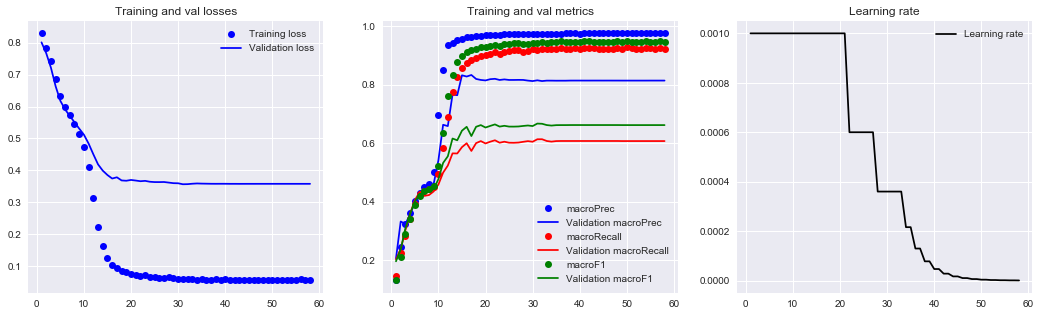

In [28]:
model2b.plot()

In [29]:
layers2c = [Embedding(input_dim=num_words, output_dim=300, input_length=padded_length),
           Dropout(rate=0.3, noise_shape=(batch_size, padded_length,  1)),
           AveragePooling1D(pool_size=8, strides=4, padding='valid', data_format='channels_last'),
           Flatten(),
           #Dense(20, activation='relu')
          ]
loss2c = fuzzy_macroF1_flip
metrics2c = [macroPrec, macroF1, macroRecall]
callbacks2c = callbacks()

model2c = BlackBox(layers=layers2c, loss=loss2c, metrics=metrics2c, callbacks=callbacks2c)
model2c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 679, 300)          17434200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 679, 300)          0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 168, 300)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50400)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 302406    
Total params: 17,736,606
Trainable params: 17,736,606
Non-trainable params: 0
_________________________________________________________________


In [30]:
model2c.fit(epochs=200)

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 55s 3ms/step - loss: 0.8266 - macroPrec: 0.1193 - macroF1: 0.1305 - macroRecall: 0.1500 - val_loss: 0.7984 - val_macroPrec: 0.2020 - val_macroF1: 0.1977 - val_macroRecall: 0.2069
Epoch 2/200
20000/20000 [==============================] - 54s 3ms/step - loss: 0.7785 - macroPrec: 0.2807 - macroF1: 0.2227 - macroRecall: 0.2302 - val_loss: 0.7651 - val_macroPrec: 0.2735 - val_macroF1: 0.2633 - val_macroRecall: 0.2592
Epoch 3/200
20000/20000 [==============================] - 54s 3ms/step - loss: 0.7427 - macroPrec: 0.3092 - macroF1: 0.2847 - macroRecall: 0.2815 - val_loss: 0.7240 - val_macroPrec: 0.3122 - val_macroF1: 0.3024 - val_macroRecall: 0.2991
Epoch 4/200
20000/20000 [==============================] - 54s 3ms/step - loss: 0.6925 - macroPrec: 0.3490 - macroF1: 0.3303 - macroRecall: 0.3300 - val_loss: 0.6685 - val_macroPrec: 0.3484 - val_macroF1: 0.3514 - val_macroRecall: 0.3551

In [31]:
model2c.evaluate()

Loss function: fuzzy_macroF1_flip. Metrics: ['macroPrec', 'macroF1', 'macroRecall']
Predicting for X_test, comparing with y_test
25000/25000 [==============================] - 17s 676us/step


[0.5044448973464966, 0.4949815654087067, 0.491155884141922, 0.49945786860466]

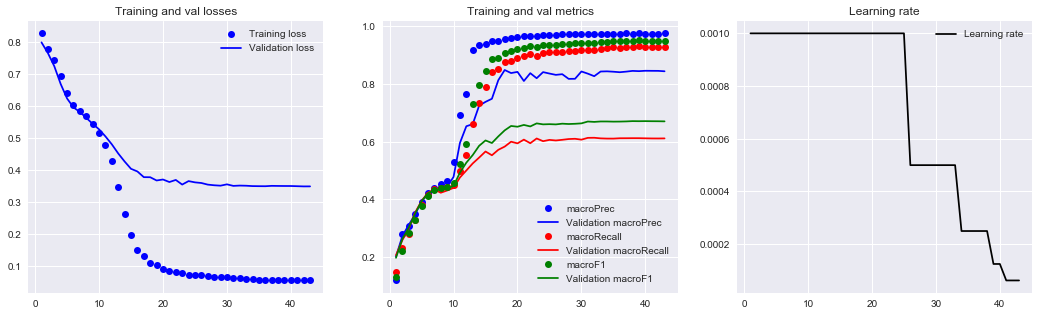

In [32]:
model2c.plot()

In [36]:
layers2d = [Embedding(input_dim=num_words, output_dim=300, input_length=padded_length),
           AveragePooling1D(pool_size=4, strides=2, padding='valid', data_format='channels_last'),
           Dropout(rate=0.3),
           Flatten(),
           #Dense(20, activation='relu')
          ]
loss2d = fuzzy_macroF1_flip
metrics2d = [macroPrec, macroF1, macroRecall]
callbacks2d = callbacks()

model2d = BlackBox(layers=layers2d, loss=loss2d, metrics=metrics2d, callbacks=callbacks2d)
model2d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 679, 300)          17434200  
_________________________________________________________________
average_pooling1d_6 (Average (None, 338, 300)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 338, 300)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 101400)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 608406    
Total params: 18,042,606
Trainable params: 18,042,606
Non-trainable params: 0
_________________________________________________________________


In [37]:
model2d.fit(epochs=200)

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 76s 4ms/step - loss: 0.8250 - macroPrec: 0.1704 - macroF1: 0.1331 - macroRecall: 0.1426 - val_loss: 0.7923 - val_macroPrec: 0.2011 - val_macroF1: 0.2027 - val_macroRecall: 0.2145
Epoch 2/200
20000/20000 [==============================] - 73s 4ms/step - loss: 0.7689 - macroPrec: 0.2871 - macroF1: 0.2339 - macroRecall: 0.2409 - val_loss: 0.7497 - val_macroPrec: 0.2880 - val_macroF1: 0.2913 - val_macroRecall: 0.2949
Epoch 3/200
20000/20000 [==============================] - 72s 4ms/step - loss: 0.7108 - macroPrec: 0.3490 - macroF1: 0.3226 - macroRecall: 0.3213 - val_loss: 0.6763 - val_macroPrec: 0.3485 - val_macroF1: 0.3495 - val_macroRecall: 0.3510
Epoch 4/200
20000/20000 [==============================] - 73s 4ms/step - loss: 0.6361 - macroPrec: 0.3997 - macroF1: 0.3856 - macroRecall: 0.3878 - val_loss: 0.6124 - val_macroPrec: 0.4022 - val_macroF1: 0.4062 - val_macroRecall: 0.4104

In [38]:
model2d.evaluate()

Loss function: fuzzy_macroF1_flip. Metrics: ['macroPrec', 'macroF1', 'macroRecall']
Predicting for X_test, comparing with y_test
25000/25000 [==============================] - 22s 891us/step


[0.512673125, 0.4819299135875702, 0.47994425030708315, 0.49057413378715514]

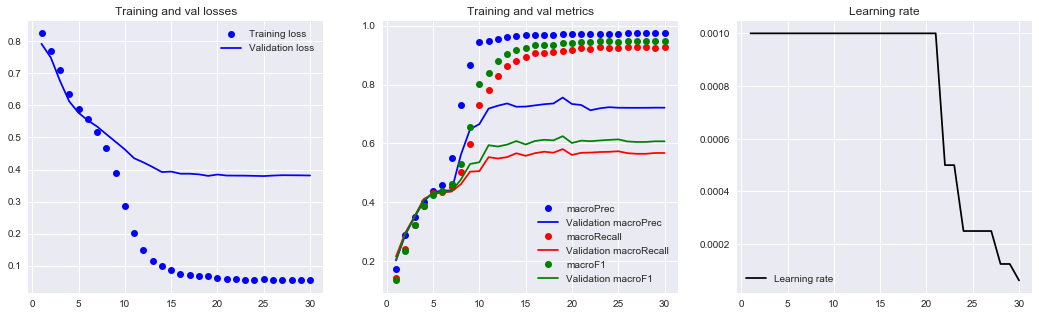

In [39]:
model2d.plot()

In [21]:
# simplistic with conv1d 

layers3 = [Embedding(input_dim=num_words, output_dim=200, input_length=padded_length),
           Dropout(rate=0.5),
           AveragePooling1D(pool_size=4, strides=2, padding='valid', data_format='channels_last'),
           Flatten(),
           Dense(20)
          ]
loss3 = fuzzy_macroF1_flip
metrics3 = [macroPrec, macroF1, macroRecall]
callbacks3 = callbacks()

model3 = BlackBox(layers=layers3, loss=loss3, metrics=metrics3, callbacks=callbacks3)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 679, 200)          16620000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 679, 200)          0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 338, 200)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 67600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1352020   
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 126       
Total params: 17,972,146
Trainable params: 17,972,146
Non-trainable params: 0
________________________________________________________________

In [22]:
model3.fit()

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 162s 4ms/step - loss: 0.8541 - macroPrec: 0.1228 - macroF1: 0.1234 - macroRecall: 0.1624 - val_loss: 0.8313 - val_macroPrec: 0.1950 - val_macroF1: 0.2074 - val_macroRecall: 0.2321
Epoch 2/200
40000/40000 [==============================] - 158s 4ms/step - loss: 0.7934 - macroPrec: 0.2138 - macroF1: 0.2281 - macroRecall: 0.2547 - val_loss: 0.7552 - val_macroPrec: 0.2266 - val_macroF1: 0.2521 - val_macroRecall: 0.2869
Epoch 3/200
40000/40000 [==============================] - 156s 4ms/step - loss: 0.7421 - macroPrec: 0.2503 - macroF1: 0.2647 - macroRecall: 0.3001 - val_loss: 0.7343 - val_macroPrec: 0.2443 - val_macroF1: 0.2710 - val_macroRecall: 0.3072
Epoch 4/200
40000/40000 [==============================] - 155s 4ms/step - loss: 0.7282 - macroPrec: 0.2617 - macroF1: 0.2753 - macroRecall: 0.3097 - val_loss: 0.7290 - val_macroPrec: 0.2462 - val_macroF1: 0.2740 - val_macroRecall: 0

In [23]:
model3.model.save(f"model3_trained_on{len(X_train)//1000}k.h5")

In [24]:
model3.evaluate()

Loss function: fuzzy_macroF1_flip. Metrics: ['macroPrec', 'macroF1', 'macroRecall']
Predicting for X_test, comparing with y_test
50000/50000 [==============================] - 36s 710us/step


[0.4948578056335449,
 0.5108633704662323,
 0.5044324360179901,
 0.5112158056640626]

In [31]:
from keras.models import load_model
loaded_model3 = load_model("model3_trained_on50k.h5", custom_objects={'fuzzy_macroF1_flip': fuzzy_macroF1_flip, 'macroPrec': macroPrec, 'macroF1': macroF1, 'macroRecall': macroRecall})

In [39]:
loaded_model3.save_weights('model3_weights.h5')

In [42]:
import pickle

In [43]:
pickle.dump(loaded_model3.layers[0].get_weights(), open("model3_weights.p", "wb")) 

In [44]:
my_weights = pickle.load(open("model3_weights.p", "rb"))

KeyError: 'lr'

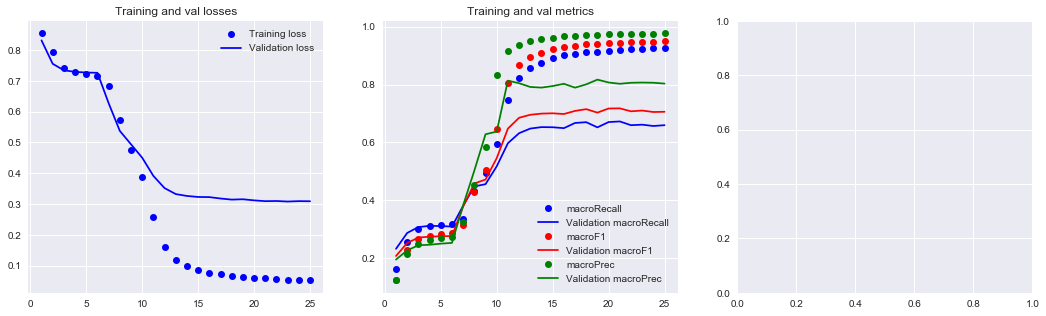

In [49]:
model3.plot()

In [77]:
model3.evaluate()

Loss function: fuzzy_macroF1_flip. Metrics: ['macroPrec', 'macroF1', 'macroRecall']
Predicting for X_test, comparing with y_test
25000/25000 [==============================] - 15s 613us/step


[0.5140339463806153,
 0.48100209486961365,
 0.47882579674720765,
 0.4894258046245575]

In [46]:
layers4 = [Embedding(input_dim=num_words, output_dim=200, input_length=padded_length, weights=my_weights, trainable=False),
           Dropout(rate=0.5),
           AveragePooling1D(pool_size=4, strides=2, padding='valid', data_format='channels_last'),
           Flatten(),
           Dense(20)
          ]
loss4 = fuzzy_macroF1_flip
metrics4 = [macroPrec, macroF1, macroRecall]
callbacks4 = callbacks()

model4 = BlackBox(layers=layers4, loss=loss4, metrics=metrics4, callbacks=callbacks4)
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 679, 200)          16620000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 679, 200)          0         
_________________________________________________________________
average_pooling1d_3 (Average (None, 338, 200)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 67600)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1352020   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 126       
Total params: 17,972,146
Trainable params: 1,352,146
Non-trainable params: 16,620,000
________________________________________________________

In [48]:
model4.fit()

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 105s 3ms/step - loss: 0.6771 - macroPrec: 0.3662 - macroF1: 0.2961 - macroRecall: 0.2839 - val_loss: 0.5796 - val_macroPrec: 0.4300 - val_macroF1: 0.4345 - val_macroRecall: 0.4418
Epoch 2/200
40000/40000 [==============================] - 106s 3ms/step - loss: 0.4767 - macroPrec: 0.6609 - macroF1: 0.5378 - macroRecall: 0.5261 - val_loss: 0.4835 - val_macroPrec: 0.7240 - val_macroF1: 0.5430 - val_macroRecall: 0.5045
Epoch 3/200
40000/40000 [==============================] - 104s 3ms/step - loss: 0.3090 - macroPrec: 0.8388 - macroF1: 0.7673 - macroRecall: 0.7337 - val_loss: 0.4192 - val_macroPrec: 0.7082 - val_macroF1: 0.5990 - val_macroRecall: 0.5597
Epoch 4/200
40000/40000 [==============================] - 116s 3ms/step - loss: 0.1833 - macroPrec: 0.9735 - macroF1: 0.8956 - macroRecall: 0.8506 - val_loss: 0.3730 - val_macroPrec: 0.8543 - val_macroF1: 0.6688 - val_macroRecall: 0

KeyError: 'lr'

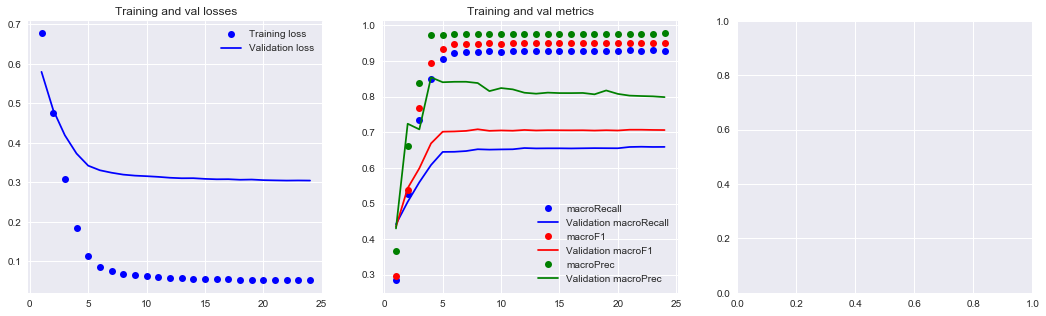

In [51]:
model4.plot()

In [ ]:
# simplistic with conv1d 

layers3b = [Embedding(input_dim=num_words, output_dim=300, input_length=padded_length, mask_zero=True),
            Conv1D(100, 4, activation='relu'),
            GlobalAveragePooling1D(),
          ]
loss3b = fuzzy_macroF1_flip
metrics3b = [macroPrec, macroF1, macroRecall]
callbacks3b = callbacks()

model3b = BlackBox(layers=layers3b, loss=loss3b, metrics=metrics3b, callbacks=callbacks3b)
model3b.summary()

In [ ]:
model3b.plot()

In [ ]:
# conv1d 

layers2b = [Embedding(input_dim=num_words, output_dim=300, input_length=padded_length),
            Dropout(rate=0.1, noise_shape=(batch_size, padded_length,  1)),
            Conv1D(100, 4, activation='relu'),
            Dropout(0.1)
            AveragePooling1D(pool_size=8, strides=4, padding='valid', data_format='channels_last'),
            Flatten(),
            Dense(20, activation='relu')
          ]
loss2b = "categorical_crossentropy"
metrics2b = [macroPrec, macroF1, macroRecall]
callbacks2b = callbacks()

model2b = BlackBox(layers=layers2b, loss=loss2b, metrics=metrics2b, callbacks=callbacks2b)
model2b.summary()

---

In [81]:
model1 = Sequential()
model1.add(Embedding(input_dim=num_words, output_dim=300, input_length=padded_length))#, mask_zero=True))
model1.add(Dropout(rate=0.1, noise_shape=(1000, padded_length,  1)))
model1.add(AveragePooling1D(pool_size=8, strides=4, padding='valid', data_format='channels_last'))
model1.add(Flatten())
model1.add(Dense(100, activation='relu'))
model1.add(Dense(n_classes, activation='softmax'))

model1.compile(loss="categorical_crossentropy", optimizer='adam', metrics=[macroF1, macroPrec, macroRecall]) # 'categorical_accuracy', 
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 679, 300)          17434200  
_________________________________________________________________
dropout_10 (Dropout)         (None, 679, 300)          0         
_________________________________________________________________
average_pooling1d_9 (Average (None, 168, 300)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 50400)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               5040100   
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 606       
Total params: 22,474,906
Trainable params: 22,474,906
Non-trainable params: 0
________________________________________________________________

In [58]:
model2 = Sequential()
model2.add(Embedding(input_dim=num_words, output_dim=300, input_length=padded_length, mask_zero=True))
model2.add(GlobalAveragePooling1D())
model2.add(Dense(n_classes, activation='softmax'))

model2.compile(loss=fuzzy_macroF1_flip, optimizer='adam', metrics=[microF1, macroF1]) # 'categorical_accuracy', 
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 679, 300)          17434200  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 1806      
Total params: 17,436,006
Trainable params: 17,436,006
Non-trainable params: 0
_________________________________________________________________


In [57]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

In [85]:
def callbacks(save_as):
    return [# ReduceLROnPlateau(),
            EarlyStopping(patience=4)
#             ModelCheckpoint(filepath=save_as, save_best_only=True)
           ]

In [86]:
# loss="categorical_crossentropy"
history1 = model1.fit(
    X_train, y_train,
    class_weight=class_weights,
    epochs=200,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=callbacks(f"keras_simple_catcrossentr_on_{len(text_train)}"),
    verbose = 1
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 63s 3ms/step - loss: 0.0565 - macroF1: 0.7533 - macroPrec: 0.8527 - macroRecall: 0.7078 - val_loss: 0.3113 - val_macroF1: 0.5181 - val_macroPrec: 0.6637 - val_macroRecall: 0.4883
Epoch 2/200
20000/20000 [==============================] - 63s 3ms/step - loss: 0.0415 - macroF1: 0.8375 - macroPrec: 0.9125 - macroRecall: 0.7968 - val_loss: 0.3250 - val_macroF1: 0.5322 - val_macroPrec: 0.6659 - val_macroRecall: 0.4965
Epoch 3/200
20000/20000 [==============================] - 63s 3ms/step - loss: 0.0309 - macroF1: 0.9202 - macroPrec: 0.9887 - macroRecall: 0.8839 - val_loss: 0.3262 - val_macroF1: 0.5623 - val_macroPrec: 0.6923 - val_macroRecall: 0.5252
Epoch 4/200
20000/20000 [==============================] - 63s 3ms/step - loss: 0.0226 - macroF1: 0.9629 - macroPrec: 0.9987 - macroRecall: 0.9387 - val_loss: 0.3348 - val_macroF1: 0.5896 - val_macroPrec: 0.6871 - val_macroRecall: 0.5526

In [26]:
# loss=fuzzy_macroF1_flip
history2 = model2.fit(
    X_train, y_train,
    class_weight=class_weights,
    epochs=200,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=callbacks,
    verbose = 1
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 41s 2ms/step - loss: 0.8807 - microF1: 0.0000e+00 - macroF1: 0.0000e+00 - val_loss: 0.8712 - val_microF1: 0.0000e+00 - val_macroF1: 0.0000e+00
Epoch 2/200
20000/20000 [==============================] - 46s 2ms/step - loss: 0.8592 - microF1: 0.0000e+00 - macroF1: 0.0000e+00 - val_loss: 0.8491 - val_microF1: 0.0000e+00 - val_macroF1: 0.0000e+00
Epoch 3/200
20000/20000 [==============================] - 41s 2ms/step - loss: 0.8404 - microF1: 0.2165 - macroF1: 0.0473 - val_loss: 0.8351 - val_microF1: 0.5924 - val_macroF1: 0.1233
Epoch 4/200
20000/20000 [==============================] - 42s 2ms/step - loss: 0.8317 - microF1: 0.6017 - macroF1: 0.1252 - val_loss: 0.8302 - val_microF1: 0.6151 - val_macroF1: 0.1269
Epoch 5/200
20000/20000 [==============================] - 46s 2ms/step - loss: 0.8280 - microF1: 0.6040 - macroF1: 0.1256 - val_loss: 0.8269 - val_microF1: 0.6151 - val_macro

Epoch 88/200
20000/20000 [==============================] - 39s 2ms/step - loss: 0.1194 - microF1: 0.9459 - macroF1: 0.9073 - val_loss: 0.3494 - val_microF1: 0.9078 - val_macroF1: 0.6498
Epoch 89/200
20000/20000 [==============================] - 45s 2ms/step - loss: 0.1174 - microF1: 0.9458 - macroF1: 0.9073 - val_loss: 0.3532 - val_microF1: 0.9087 - val_macroF1: 0.6495
Epoch 90/200
20000/20000 [==============================] - 44s 2ms/step - loss: 0.1137 - microF1: 0.9464 - macroF1: 0.9097 - val_loss: 0.3511 - val_microF1: 0.9082 - val_macroF1: 0.6548
Epoch 91/200
20000/20000 [==============================] - 39s 2ms/step - loss: 0.1172 - microF1: 0.9469 - macroF1: 0.9036 - val_loss: 0.3434 - val_microF1: 0.9090 - val_macroF1: 0.6812
Epoch 92/200
20000/20000 [==============================] - 45s 2ms/step - loss: 0.1180 - microF1: 0.9471 - macroF1: 0.9064 - val_loss: 0.3564 - val_microF1: 0.9088 - val_macroF1: 0.6462
Epoch 93/200
20000/20000 [==============================] - 45s 2

In [314]:
np.shape(X_test)

(25000, 455)

In [315]:
model.evaluate(X_test, y_test)

25000/25000 [==============================] - 6s 254us/step


[0.5094182186126709, 0.9034493243217468, 0.49392583874702456]

In [54]:
np.unique(predicted_label_test)

array(['cs', 'math', 'phys', 'q-bio', 'stat'], dtype=object)

In [48]:
np.array(label_test)

array(['q-fin', 'phys', 'cs', ..., 'phys', 'phys', 'math'], dtype=object)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [113]:
f1_score(np.array(label_test), predicted_label_test, average='macro')

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.42252345213456693

In [351]:
all_metrics = np.array(list(set(history.history.keys()) - set(['loss', 'val_loss', 'lr'])))  # WTF is lr?
metrics

array(['val_macroF1', 'microF1', 'macroF1', 'val_microF1'], dtype='<U11')

In [352]:
metrics[[not metric.startswith('val_') for metric in metrics]]

array(['microF1', 'macroF1'], dtype='<U11')

In [359]:
['*',  'o', 'd']

['*', 'o', 'd', '*', 'o', 'd']

In [61]:
markers = ['-', 'o',  'd', '*']
marker = zip(markers, markers)
list(marker)

[('-', '-'), ('o', 'o'), ('d', 'd'), ('*', '*')]

In [66]:
import matplotlib.pyplot as plt

def plot_history(history):
    
    plt.figure(figsize=(12, 5))
    
    loss = history.history['loss']
    x = range(1, len(loss) + 1)
    val_loss = history.history['val_loss']
    plt.subplot(1, 2, 1)    
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')  
    plt.legend()
    
    all_metrics = np.array(list(set(history.history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 2, 2)
    markers = ['o', '-',  'd', '*']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history.history[metric]
        val_results = history.history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'b'+mark1, label=metric)
        plt.plot(x, val_results, 'r'+mark2, label='Validation '+metric)
        plt.title('Training and validation metrics')
        
    plt.legend()

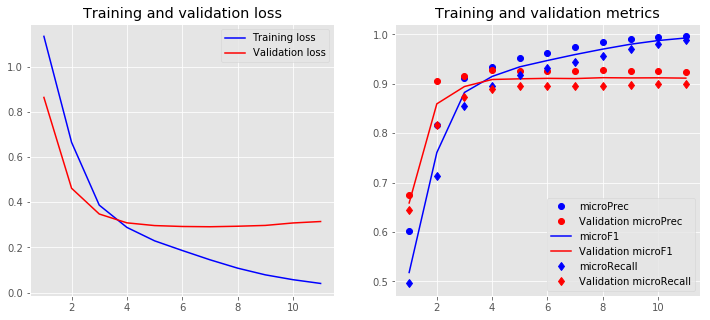

In [67]:
plt.style.use('ggplot')
plot_history(history1)